# Load and format data into tables
This code finds data from previous runs of code and formats it nicely. It also calculates some statistics used in the paper for general information - specifically, the relationship between different greenness metrics, and checks the length of the COPs. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import stats

In [2]:
# Code choices to decide what to make into tables.
version = "version26"
# Add the subfolders here for analysis, e.g. OPEC_Conference, OPEC_conf_29. The empty string generates the COP 
subfolderlist = [""]
# Name of folders to open
subsubfolder_labels = {
    "constsust_20": "Neutral rated 20", 
    "constsust_32": "Neutral rated 32", 
    "greencred_20": "Green rated 20",
    "greencred_32": "Green rated 32",
    "fossil_20": "Fossil 20", 
    "fossil_32": "Fossil 32", 
    "renewable_20": "Renewable 20",
    "renewable_all": "Renewable 32",
    #"SandPESG_32": "S&P ESG environmental 32",
    #"SandP_32": "S&P ESG overall 32",
}
# Directory of results. 
results_dir = "./output/"
# May want to use results with different length factors for ranking methods and OLS methods. 
afterlength = 0
olsafterlength = 0

# The neutral group whose behaviour is accounted for in the difference model, e.g. constsust_32 or SandP
neutralGroup = "constsust_32"
# Include the whole period results?
includeWholePeriod = True
# Include the alternative model of least squares fitting
includeSM = False
# Include data on background stats?
include_background = True
# The variable used to denote the time-value of money, either "Norm^IRX" or the empty string if none is used.
interestratename = "_Norm^IRX"

# File names shouldn't need editing
delaystring = "" if ((afterlength==0)&(olsafterlength==0)) else f"Delay_{afterlength}_{olsafterlength}"
copnamestring = "_COPyear"
kstestfolder = f"before0_after{afterlength}_norm{neutralGroup}_1"
olstestfolder = f"before0_after{olsafterlength}_norm{neutralGroup}_cleaned"
kstestfilename = "Kolmogorov_Smirnoff_test_results.csv"
olsresultsfile = f"OLSsummary{interestratename}.txt"
olsresultsSqfile = f"OLSsummaryDailyVar{interestratename}.txt"
olsresultsCopYearfile = f"OLSsummary_COPyear{interestratename}.txt"
olsresultsSqCopYearfile = f"OLSsummaryDailyVar_COPyear{interestratename}.txt"
FEOLS_filename_diff = f"FEOLSdataSummaryDayChange_x{copnamestring}{interestratename}.csv"
FEOLS_filename_range = f"FEOLSdataSummaryDayVar_x{copnamestring}{interestratename}.csv"

diffCOPYearTrendFile = "COPyearDiffTrend.csv"
varCOPYearTrendFile = "COPyearVarianceTrend.csv"

In [3]:
# Define some functions required to read the COP values from the OLS regression table
def extract_cop_value(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    for line in lines:
        if line.strip().startswith("COP"):
            # Split the line to find the COP value
            parts = line.replace(",", " ").split()
            if len(parts) > 1:
                # Reformat the percentage for convenience
                parts = [float(x) for x in parts[1:]]
                return parts
    return None  # Return None if "COP" is not found in the file

# This function reads the COP-year values from the OLS regression tables
def extract_cop_year_value(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    for line in lines:
        if (line.strip().startswith("COPnumbers")) | (line.strip().startswith("COPyear")):
            # Split the line to find the COP value
            parts = line.replace(",", " ").split()
            if len(parts) > 1:
                # Reformat the percentage for convenience
                parts = [float(x) for x in parts[1:]]
                return parts
    return None  # Return None if "COP" is not found in the file

# Function to read the trend line experiment data
def extract_cop_year_trend(file_path):
    df = pd.read_csv(file_path, index_col=0)
    return df.loc["x1", :]
def extract_background_stats(file_path):
    return pd.read_csv(file_path.replace("FEOLSdataSummary", "BackgroundSummaryFEOLS"), index_col=0)

In [4]:
subsubfolder_labels

{'constsust_20': 'Neutral rated 20',
 'constsust_32': 'Neutral rated 32',
 'greencred_20': 'Green rated 20',
 'greencred_32': 'Green rated 32',
 'fossil_20': 'Fossil 20',
 'fossil_32': 'Fossil 32',
 'renewable_20': 'Renewable 20',
 'renewable_all': 'Renewable 32'}

In [5]:
def convert_one_tailed_to_two(p):
    return 1-2 * abs(p-0.5)
def stars(pval: float) -> str:
    # Return significance stars for a p-value.
    return f'{pval:.{prec}f}' + ("**" if pval < 0.01 else ("*" if pval < 0.05 else ""))

In [26]:
prec = 4  # Precision in tables (# decimal places)
# Workhorse routine to extract data from file

# When reading FEOLS files, we may wish to access the first set of values (calculated with standard errors)
# or the second set of values (calculated with errors clustered by company). In the first case, use "", in the latter 
# use "_crv1". 
shift_FEOLS_read_column = "_crv1"
for subfolder in subfolderlist:
    results = []
    results_sup = []
    background_stats_results = []
    for key, val in subsubfolder_labels.items():
        # Fix filename variation
        tempolstestfolder = olstestfolder.replace(neutralGroup, "None") if ("constsust" in key) else olstestfolder
        # Optionally load whole period data
        if includeWholePeriod:
            tempkstestfolder = kstestfolder.replace(neutralGroup, "None") if ("constsust" in key) else kstestfolder
            subresult = pd.read_csv(
                os.path.join(results_dir, version, subfolder, key, tempkstestfolder, kstestfilename)
            )
            if type(subresult["testStat"][0]) == type(""):
                subresult = subresult.iloc[:-1, :]
                subresult["testStat"] = pd.to_numeric(subresult["testStat"])
            diffPeriodCOPyearTrend = extract_cop_year_trend(
                 os.path.join(results_dir, version, subfolder, key, tempkstestfolder, diffCOPYearTrendFile)
            )
            varPeriodCOPyearTrend = extract_cop_year_trend(
                 os.path.join(results_dir, version, subfolder, key, tempkstestfolder, varCOPYearTrendFile)
            )
        # Extract the results for daily routines
        subOLSresult = extract_cop_value(
            os.path.join(results_dir, version, subfolder, key, tempolstestfolder, olsresultsfile)
        )
        subOLSsqresult = extract_cop_value(
            os.path.join(results_dir, version, subfolder, key, tempolstestfolder, olsresultsSqfile)
        )
        subOLSresultCOPyearTerm = extract_cop_year_value(
            os.path.join(results_dir, version, subfolder, key, tempolstestfolder, olsresultsCopYearfile)
        )
        subOLSsqresultCOPyearTerm = extract_cop_year_value(
            os.path.join(results_dir, version, subfolder, key, tempolstestfolder, olsresultsSqCopYearfile)
        )
        # Fix filenames for recovering daily routines
        FEOLS_file_diff_use = FEOLS_filename_diff.replace("_x", "") if ("constsust" in key) else FEOLS_filename_diff
        FEOLS_file_range_use = FEOLS_filename_range.replace("_x", "") if ("constsust" in key) else FEOLS_filename_range
        
        # Read the files and align the column names
        FEOLS_COP_diff = pd.read_csv(
            os.path.join(results_dir, version, subfolder, key, tempolstestfolder, FEOLS_file_diff_use.replace(copnamestring, "")),
            index_col=0
        ).rename(columns={"Coefficient.1": "Coffeicient"})
        FEOLS_COP_range = pd.read_csv(
            os.path.join(results_dir, version, subfolder, key, tempolstestfolder, FEOLS_file_range_use.replace(copnamestring, "")),
            index_col=0
        ).rename(columns={"Coefficient.1": "Coffeicient"})
        FEOLS_COP_trend_diff = pd.read_csv(
            os.path.join(results_dir, version, subfolder, key, tempolstestfolder, FEOLS_file_diff_use),
            index_col=0
        ).rename(columns={"Coefficient.1": "Coffeicient"})
        FEOLS_COP_trend_range = pd.read_csv(
            os.path.join(results_dir, version, subfolder, key, tempolstestfolder, FEOLS_file_range_use),
            index_col=0
        ).rename(columns={"Coefficient.1": "Coffeicient"})
        
        # Display whole period stats
        if includeWholePeriod:
            results.append(
                pd.Series({
                    "Portfolio": val,
                    "Difference rank": f'{subresult.loc[subresult["Test"]=="RankTestDiff", "testStat"].iloc[0]:.3f}', 
                    "Difference probability": f'{convert_one_tailed_to_two(subresult.loc[subresult["Test"]=="RankTestDiff", "pval"].iloc[0]):.3f}', 
                    "gSD rank": f'{subresult.loc[subresult["Test"]=="RankTestgeoSD", "testStat"].iloc[0]:.3f}',
                    "gSD probability": f'{convert_one_tailed_to_two(subresult.loc[subresult["Test"]=="RankTestgeoSD", "pval"].iloc[0]):.3f}', 
                    "COP linear diff pyfixedefs": f'{FEOLS_COP_diff.loc["COP", "Coefficient"+shift_FEOLS_read_column]:.{prec}f} ± {FEOLS_COP_diff.loc["COP", "Std. Error"+shift_FEOLS_read_column]:.{prec}f}',
                    "COP linear diff pyfixedefs p-val": stars(FEOLS_COP_diff.loc["COP", "P-value"+shift_FEOLS_read_column]),
                    "COP linear range pyfixedefs": f'{FEOLS_COP_range.loc["COP", "Coefficient"+shift_FEOLS_read_column]:.{prec}f} ± {FEOLS_COP_range.loc["COP", "Std. Error"+shift_FEOLS_read_column]:.{prec}f}',
                    "COP linear range pyfixedefs p-val": stars(FEOLS_COP_range.loc["COP", "P-value"+shift_FEOLS_read_column])
                })
            )
            results_sup.append(
                pd.Series({
                    "Portfolio": val,
                    "COP period trend diff fit": f'{diffPeriodCOPyearTrend["BestEstimate"]:.{prec}f} [{diffPeriodCOPyearTrend["LowerConf"]:.{prec}f} - {diffPeriodCOPyearTrend["UpperConf"]:.4f}]',
                    "COP period trend gSD fit": f'{diffPeriodCOPyearTrend["BestEstimate"]:.{prec}f} [{diffPeriodCOPyearTrend["LowerConf"]:.{prec}f} - {diffPeriodCOPyearTrend["UpperConf"]:.4f}]',
                    "COP diff trend pyfixedefs x1000": f'{1000*FEOLS_COP_trend_diff.loc["COPyear", "Coefficient"+shift_FEOLS_read_column]:.{prec}f} ± {1000*FEOLS_COP_trend_diff.loc["COPyear", "Std. Error"+shift_FEOLS_read_column]:.{prec}f}',
                    "COP diff trend pval pyfixedefs": stars(FEOLS_COP_trend_diff.loc["COPyear", "P-value"+shift_FEOLS_read_column]),
                    "COP range trend pyfixedefs x1000": f'{1000*FEOLS_COP_trend_range.loc["COPyear", "Coefficient"+shift_FEOLS_read_column]:.{prec}f} ± {1000*FEOLS_COP_trend_range.loc["COPyear", "Std. Error"+shift_FEOLS_read_column]:.{prec}f})',
                    "COP range trend pval pyfixedefs": stars(FEOLS_COP_trend_range.loc["COPyear", "P-value"+shift_FEOLS_read_column])
                })
            )
        else:
            results.append(
                pd.Series({
                    "Portfolio": val,
                    "COP linear diff pyfixedefs": f'{FEOLS_COP_diff.loc["COP", "Coefficient"+shift_FEOLS_read_column]:.{prec}f} ± {FEOLS_COP_diff.loc["COP", "Std. Error"+shift_FEOLS_read_column]:.{prec}f}',
                    "COP linear diff pyfixedefs p-val": stars(FEOLS_COP_diff.loc["COP", "P-value"+shift_FEOLS_read_column]),
                    "COP linear range pyfixedefs": f'{FEOLS_COP_range.loc["COP", "Coefficient"+shift_FEOLS_read_column]:.{prec}f} ± {FEOLS_COP_range.loc["COP", "Std. Error"+shift_FEOLS_read_column]:.{prec}f}',
                    "COP linear range pyfixedefs p-val": stars(FEOLS_COP_range.loc["COP", "P-value"+shift_FEOLS_read_column])
                })
            )
            results_sup.append(
                pd.Series({
                    "Portfolio": val,
                    "COP diff trend pyfixedefs x1000": f'{1000*FEOLS_COP_trend_diff.loc["COPyear", "Coefficient"+shift_FEOLS_read_column]:.{prec}f} ± {1000*FEOLS_COP_trend_diff.loc["COPyear", "Std. Error"+shift_FEOLS_read_column]:.{prec}f}',
                    "COP diff trend pval pyfixedefs": stars(FEOLS_COP_trend_diff.loc["COPyear", "P-value"+shift_FEOLS_read_column]),
                    "COP range trend pyfixedefs x1000": f'{1000*FEOLS_COP_trend_range.loc["COPyear", "Coefficient"+shift_FEOLS_read_column]:.{prec}f} ± {1000*FEOLS_COP_trend_range.loc["COPyear", "Std. Error"+shift_FEOLS_read_column]:.{prec}f})',
                    "COP range trend pval pyfixedefs": stars(FEOLS_COP_trend_range.loc["COPyear", "P-value"+shift_FEOLS_read_column])
                })
            )

        if includeSM:
            results[-1] = pd.concat([
                results[-1], 
                pd.Series({
                    "COP linear diff term": f'{subOLSresult[0]:.{prec}f} ± {subOLSresult[1]:.{prec}f}',
                    "COP linear diff p": stars(subOLSresult[3]),
                    "COP linear range term": f'{subOLSsqresult[0]:.{prec}f} ± {subOLSsqresult[1]:.{prec}f}',
                    "COP linear range p": stars(subOLSsqresult[3])
                }),
            ])
            results_sup[-1] = pd.concat([
                results_sup[-1], 
                pd.Series({
                    "COP trend linear diff term": f'{subOLSresultCOPyearTerm[0]:.{prec}f} ({subOLSresultCOPyearTerm[3]:.{prec}f})' + stars(subOLSresultCOPyearTerm[3]),
                    "COP trend linear range term": f'{subOLSsqresultCOPyearTerm[0]:.{prec}f} ({subOLSsqresultCOPyearTerm[3]:.{prec}f})' + stars(subOLSsqresultCOPyearTerm[3])
                })  
            ])
        if include_background:
            # Extract stats for background statistics
            background_stats_results.append(
                extract_background_stats(
                    os.path.join(results_dir, version, subfolder, key, tempolstestfolder, 
                        FEOLS_file_range_use.replace("FEOLSdataSummary", "BackgroundSummaryFEOLS")
                    )
                )
            )
    results = pd.DataFrame(results)
    results.to_csv(
        os.path.join(results_dir, version, subfolder, f"ResultsSummaryTable{interestratename}_Norm{neutralGroup}{delaystring}.csv"), 
        encoding='utf-8-sig'
    )
    results_sup = pd.DataFrame([r.to_dict() for r in results_sup])
    results_sup.to_csv(
        os.path.join(results_dir, version, subfolder, f"ResultsSummarySupplementaryTable{interestratename}_Norm{neutralGroup}{delaystring}.csv"), 
        encoding='utf-8-sig'
    )
    if include_background:
        # Format background stats for saving
        background_stats_results = pd.concat(background_stats_results)
        background_stats_results["Variable"] = background_stats_results["Variable"].str.replace("_x", "")
        del background_stats_results["Normalisation"]
        background_pivot = background_stats_results.pivot(index=["Group", "Datapoints", "Times"], columns=["Variable"], values=["Mean", "Standard deviation", "COP mean", "COP std"]).reset_index()
        background_pivot.columns = [(f"{val[0]}" if val[1] == "" else val[0] + " " + ('Daily change' if val[1]=='DayChange' else 'Daily range')) for val in background_pivot.columns]
        background_pivot.to_csv(
            os.path.join(results_dir, version, subfolder, f"ResultsSummaryBackgroundTable{interestratename}_Norm{neutralGroup}{delaystring}.csv"),
            encoding='utf-8-sig'
        )

In [24]:
background_pivot

Group Datapoints Times      Mean            \
Variable                                 DayChange    DayVar   
0          constsust_20     144833  7777  0.000648  0.019389   
1          constsust_32     225015  7778  0.000648  0.020612   
2             fossil_20     137007  7783  0.000577  0.021735   
3             fossil_32     213706  7785  0.000612  0.023093   
4          greencred_20     130272  7788  0.000998  0.027063   
5          greencred_32     221055  7788  0.000873  0.025573   
6          renewable_20      97563  7815  0.000670  0.036528   
7         renewable_all     154788  7827  0.000708  0.041723   

         Standard deviation            COP mean             COP std            
Variable          DayChange    DayVar DayChange    DayVar DayChange    DayVar  
0                  0.018306  0.014705  0.000830  0.019728  0.017988  0.014391  
1                  0.019581  0.015498  0.000803  0.020948  0.019327  0.015324  
2                  0.020266  0.015128  0.000290  0.021865  0.020288  0.014566  
3                  0.021460  0.018872  0.000427  0.023151  0.021528  0.016330  
4                  0.025107  0.019467  0.002394  0.027781  0.026678  0.019891  
5                  0.023714  0.018437  0.001868  0.026220  0.024791  0.018821  
6                  0.033573  0.028339  0.000058  0.037725  0.033085  0.027493  
7                  0.038282  0.034585  0.000134  0.042799  0.038305  0.034239

In [7]:
results

,Portfolio,Difference rank,Difference probability,gSD rank,gSD probability,COP linear diff pyfixedefs,COP linear diff pyfixedefs p-val,COP linear range pyfixedefs,COP linear range pyfixedefs p-val
0,Neutral rated 20,0.652,0.743,0.348,0.658,0.0002 ± 0.0002,0.3825,0.0005 ± 0.0002,0.0061**
1,Neutral rated 32,0.739,0.572,0.478,0.914,0.0002 ± 0.0002,0.3364,0.0005 ± 0.0001,0.0012**
2,Green rated 20,1.000,0.059,0.957,0.145,0.0013 ± 0.0004,0.0058**,0.0003 ± 0.0003,0.3692
3,Green rated 32,1.000,0.059,0.957,0.145,0.0009 ± 0.0003,0.0035**,0.0003 ± 0.0002,0.1879
4,Fossil 20,0.261,0.487,0.826,0.401,-0.0005 ± 0.0002,0.0169*,0.0000 ± 0.0002,0.8574
5,Fossil 32,0.261,0.487,0.870,0.316,-0.0004 ± 0.0002,0.0460*,0.0001 ± 0.0002,0.7834
6,Renewable 20,0.304,0.572,0.696,0.658,-0.0006 ± 0.0005,0.2260,0.0009 ± 0.0005,0.0609
7,Renewable 32,0.043,0.059,0.696,0.658,-0.0006 ± 0.0004,0.1378,0.0009 ± 0.0005,0.0715


In [8]:
results_sup

,Portfolio,COP period trend diff fit,COP period trend gSD fit,COP diff trend pyfixedefs x1000,COP diff trend pval pyfixedefs,COP range trend pyfixedefs x1000,COP range trend pval pyfixedefs
0,Neutral rated 20,-0.0076 [-0.1358 - 0.1206],-0.0076 [-0.1358 - 0.1206],-0.0009 ± 0.0140,0.9489,0.0426 ± 0.0286),0.1538
1,Neutral rated 32,-0.0068 [-0.1425 - 0.1289],-0.0068 [-0.1425 - 0.1289],0.0081 ± 0.0155,0.6034,0.0362 ± 0.0235),0.1342
2,Green rated 20,0.0446 [-0.1401 - 0.2293],0.0446 [-0.1401 - 0.2293],0.0100 ± 0.0366,0.7872,-0.0362 ± 0.0290),0.2271
3,Green rated 32,0.0633 [-0.0682 - 0.1948],0.0633 [-0.0682 - 0.1948],0.0526 ± 0.0298,0.0879,-0.0303 ± 0.0198),0.1373
4,Fossil 20,-0.0608 [-0.1855 - 0.0638],-0.0608 [-0.1855 - 0.0638],-0.0826 ± 0.0291,0.0105*,-0.0474 ± 0.0224),0.0479*
5,Fossil 32,-0.0598 [-0.1913 - 0.0717],-0.0598 [-0.1913 - 0.0717],-0.0727 ± 0.0245,0.0056**,-0.0238 ± 0.0213),0.2730
6,Renewable 20,-0.1736 [-0.3280 - -0.0192],-0.1736 [-0.3280 - -0.0192],-0.2032 ± 0.0531,0.0011**,0.1485 ± 0.0685),0.0431*
7,Renewable 32,-0.1002 [-0.3030 - 0.1025],-0.1002 [-0.3030 - 0.1025],-0.1340 ± 0.0482,0.0092**,0.2917 ± 0.0756),0.0005**


In [20]:
if include_background:
    print(background_stats_results)

           Group   Variable      Mean  Standard deviation  Datapoints  \
0   constsust_20  DayChange  0.000648            0.018306      144833   
0   constsust_20     DayVar  0.019389            0.014705      144833   
0   constsust_32  DayChange  0.000648            0.019581      225015   
0   constsust_32     DayVar  0.020612            0.015498      225015   
0   greencred_20  DayChange  0.000998            0.025107      130272   
0   greencred_20     DayVar  0.027063            0.019467      130272   
0   greencred_32  DayChange  0.000873            0.023714      221055   
0   greencred_32     DayVar  0.025573            0.018437      221055   
0      fossil_20  DayChange  0.000577            0.020266      137007   
0      fossil_20     DayVar  0.021735            0.015128      137007   
0      fossil_32  DayChange  0.000612            0.021460      213706   
0      fossil_32     DayVar  0.023093            0.018872      213706   
0   renewable_20  DayChange  0.000670            0.

# Plot ESG comparisons

In [10]:
ratings = pd.read_csv("./input/companiesmarketcap.com - Companies ranked by Market Cap - CompaniesMarketCap.com.csv")

In [11]:
ratings.corr(method="pearson")

,Rank,marketcap,price (USD),Sustainalytics value,Sustainalytics 20-30,Sustainalytics <20,Sustainalytics >30,Unnamed: 11,S&P ESG environmental,S&P ESG,Unnamed: 14,Unnamed: 15,Unnamed: 16,Rank sustainalytics,Rank S&P,Unnamed: 19
Rank,1.000000,-0.251557,-0.132013,-0.112814,-0.346905,0.433565,-0.072949,NaN,0.039852,0.190374,NaN,NaN,NaN,0.108612,-0.017011,-0.171475
marketcap,-0.251557,1.000000,0.061896,0.100870,0.079267,-0.111027,-0.009509,NaN,-0.037399,-0.154949,NaN,NaN,NaN,-0.196566,0.138675,0.231930
price (USD),-0.132013,0.061896,1.000000,-0.227237,-0.092921,0.190091,-0.131990,NaN,0.005933,-0.001764,NaN,NaN,NaN,0.448421,-0.257168,-0.235488
Sustainalytics value,-0.112814,0.100870,-0.227237,1.000000,0.261623,-0.654345,0.644923,NaN,-0.505020,-0.497042,NaN,NaN,NaN,-0.929072,0.641157,0.598769
Sustainalytics 20-30,-0.346905,0.079267,-0.092921,0.261623,1.000000,-0.720243,-0.224934,NaN,-0.016485,-0.050836,NaN,NaN,NaN,-0.336320,-0.079131,0.053483
Sustainalytics <20,0.433565,-0.111027,0.190091,-0.654345,-0.720243,1.000000,-0.300668,NaN,0.318057,0.320283,NaN,NaN,NaN,0.875814,-0.449071,-0.498877
Sustainalytics >30,-0.072949,-0.009509,-0.131990,0.644923,-0.224934,-0.300668,1.000000,NaN,-0.318176,-0.307435,NaN,NaN,NaN,-0.609290,0.478951,0.399100
Unnamed: 11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S&P ESG environmental,0.039852,-0.037399,0.005933,-0.505020,-0.016485,0.318057,-0.318176,NaN,1.000000,0.873761,NaN,NaN,NaN,0.619692,-0.974435,-0.841170
S&P ESG,0.190374,-0.154949,-0.001764,-0.497042,-0.050836,0.320283,-0.307435,NaN,0.873761,1.000000,NaN,NaN,NaN,0.625328,-0.860466,-0.983339


In [12]:
ratings

,Rank,Name,Symbol,marketcap,price (USD),country,Exclude,Sustainalytics value,Sustainalytics 20-30,Sustainalytics <20,Sustainalytics >30,Unnamed: 11,S&P ESG environmental,S&P ESG,Unnamed: 14,Unnamed: 15,Unnamed: 16,Rank sustainalytics,Rank S&P,Unnamed: 19
0,1,Apple,AAPL,2.870000e+12,184.225,United States,NaN,16.7,0.0,1.0,0.0,NaN,54.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Microsoft,MSFT,2.830000e+12,381.240,United States,NaN,15.4,0.0,1.0,0.0,NaN,73.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Saudi Aramco,2222.SR,2.120000e+12,8.780,Saudi Arabia,FF and too new,47.2,0.0,0.0,0.0,NaN,13.0,18.0,NaN,NaN,NaN,0.017544,0.974138,0.974138
3,4,Alphabet (Google),GOOG,1.780000e+12,143.250,United States,NaN,24.2,1.0,0.0,0.0,NaN,66.0,47.0,NaN,NaN,NaN,0.359649,0.224138,0.465517
4,5,Amazon,AMZN,1.590000e+12,153.560,United States,NaN,29.9,1.0,0.0,0.0,NaN,34.0,22.0,NaN,NaN,NaN,0.140351,0.844828,0.965517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7968,7969,Ozon,OZON.ME,0.000000e+00,32.020,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7969,7970,Emirates NBD Bank PJSC,EMIRATESNBD.AE,0.000000e+00,0.000,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7970,7971,Emaar Properties,EMAAR.AE,0.000000e+00,0.000,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7971,7972,Energy Harbor,ENGH,0.000000e+00,0.000,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
from matplotlib import pyplot
pyplot.rcParams['figure.dpi'] = 600

Corresponding S&P total green limit is 49.71592339204981


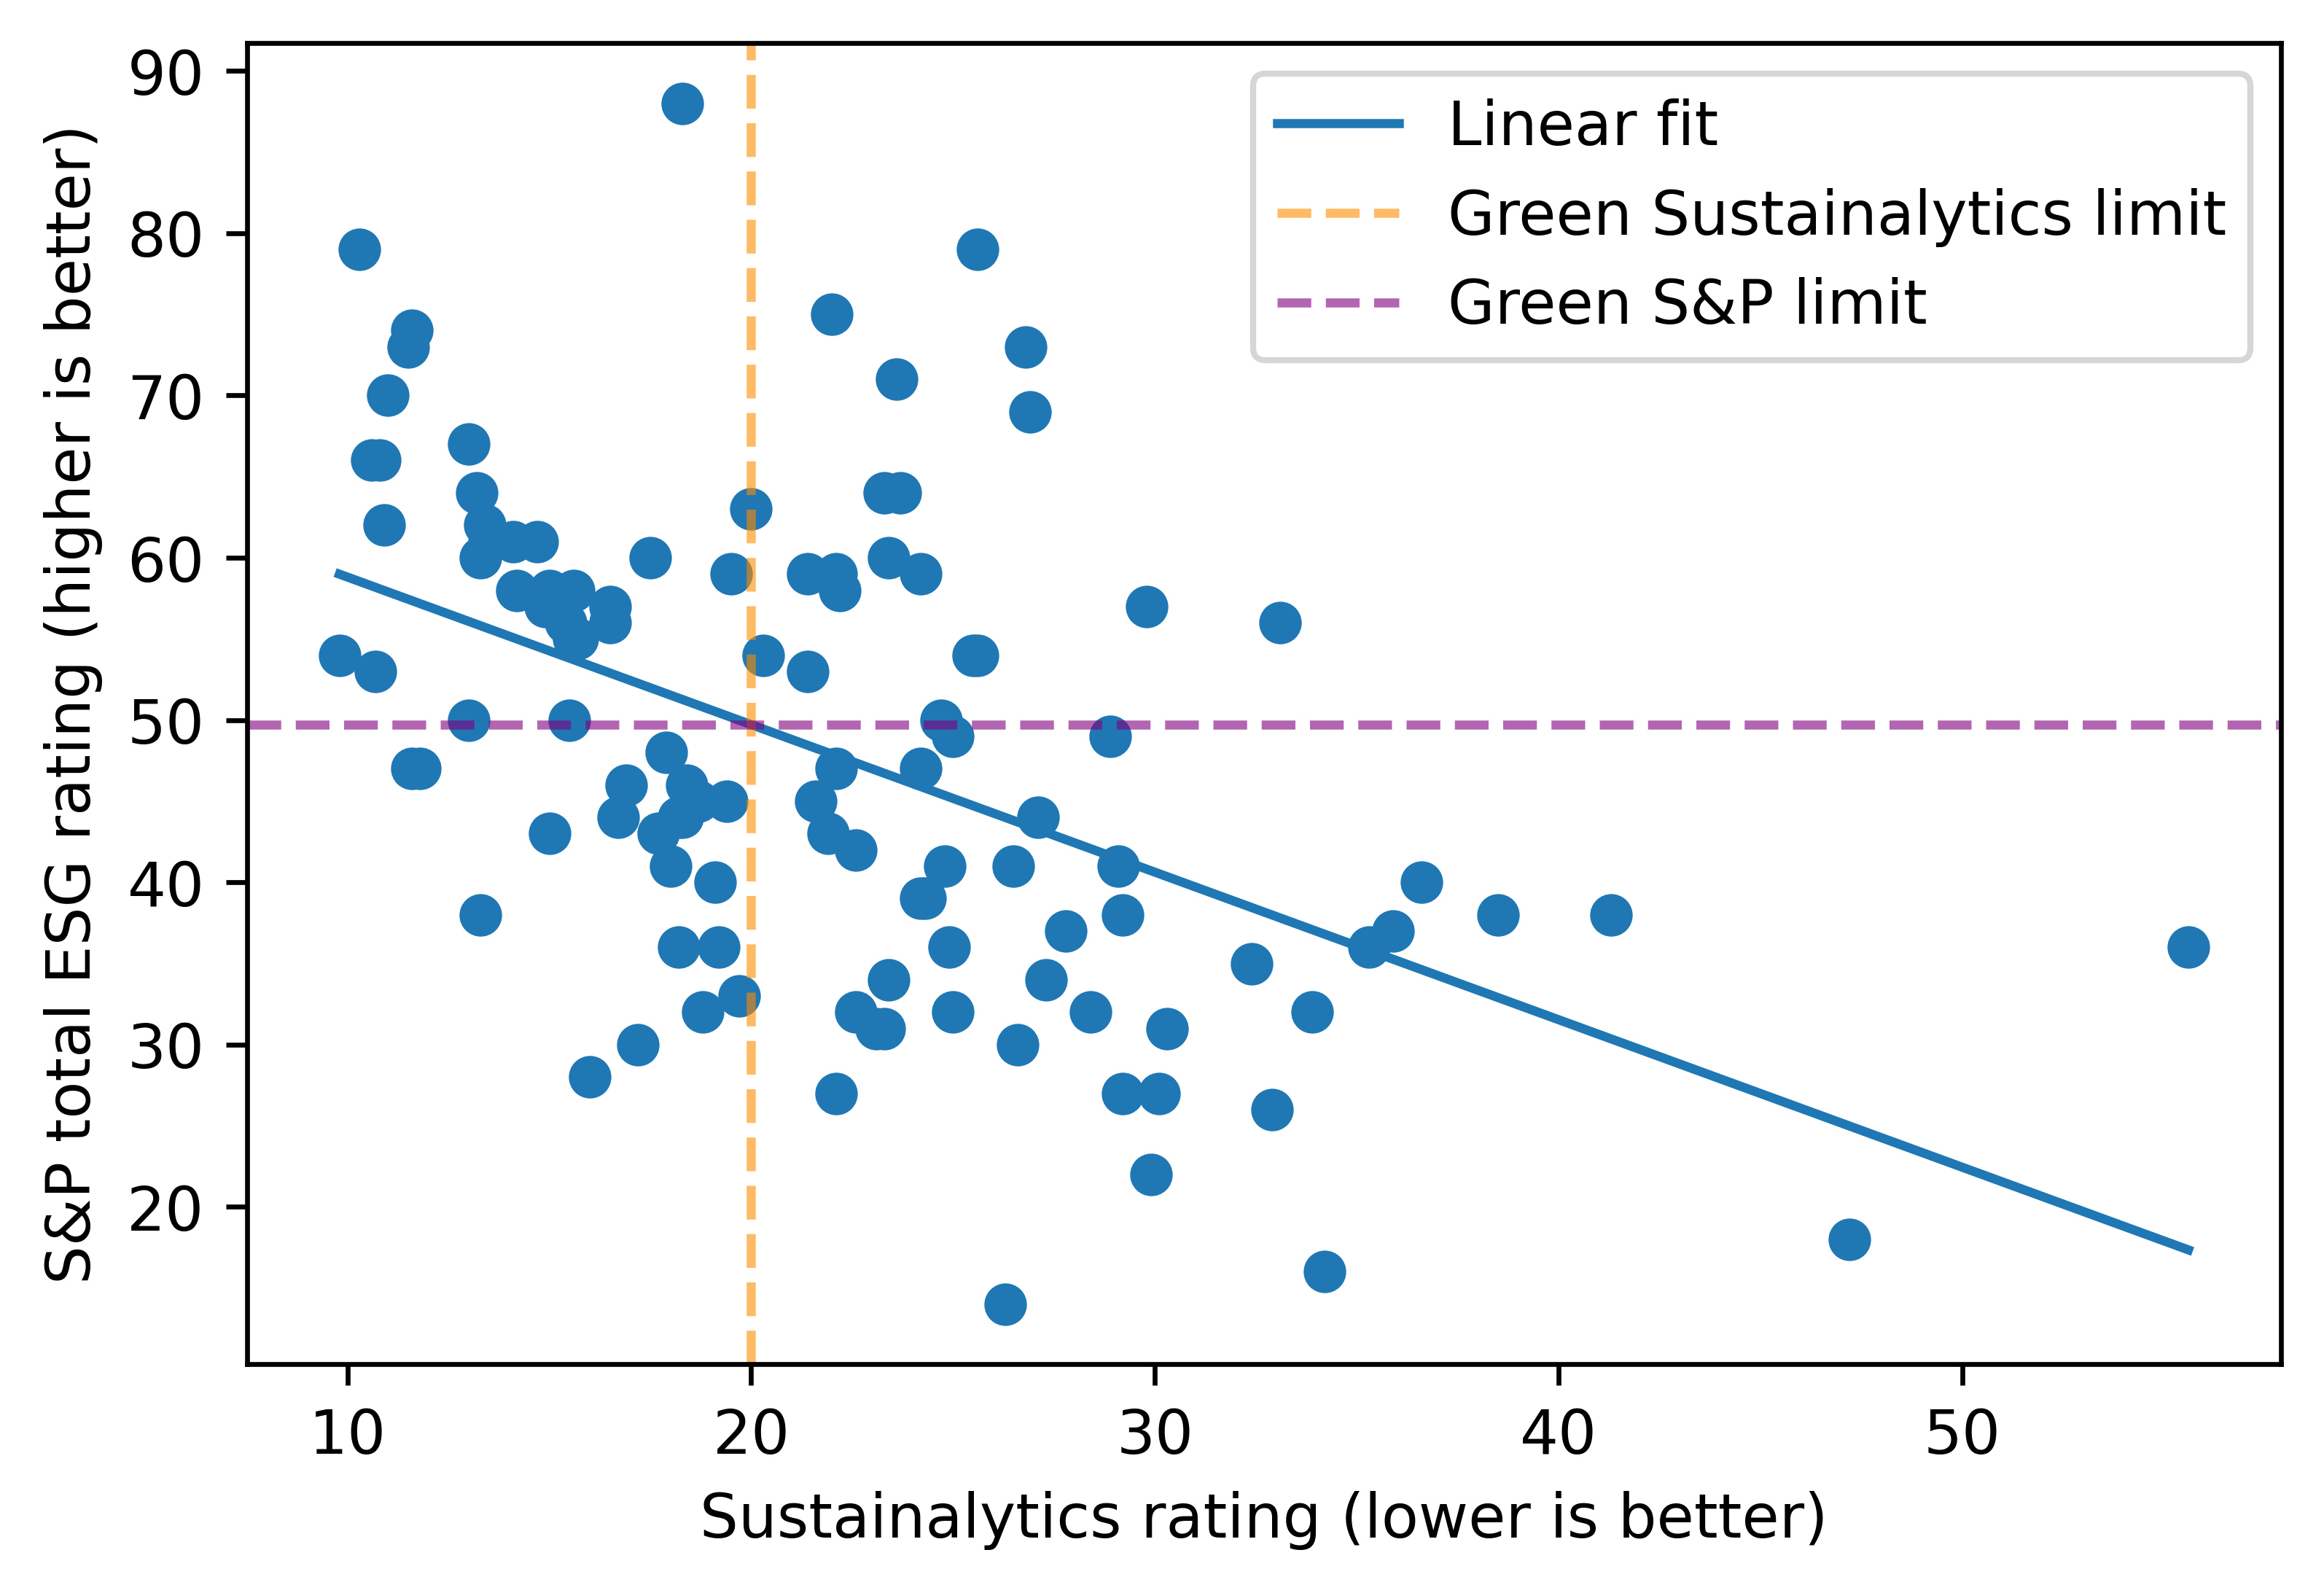

Corresponding S&P environmental green limit is 55.6622106974051


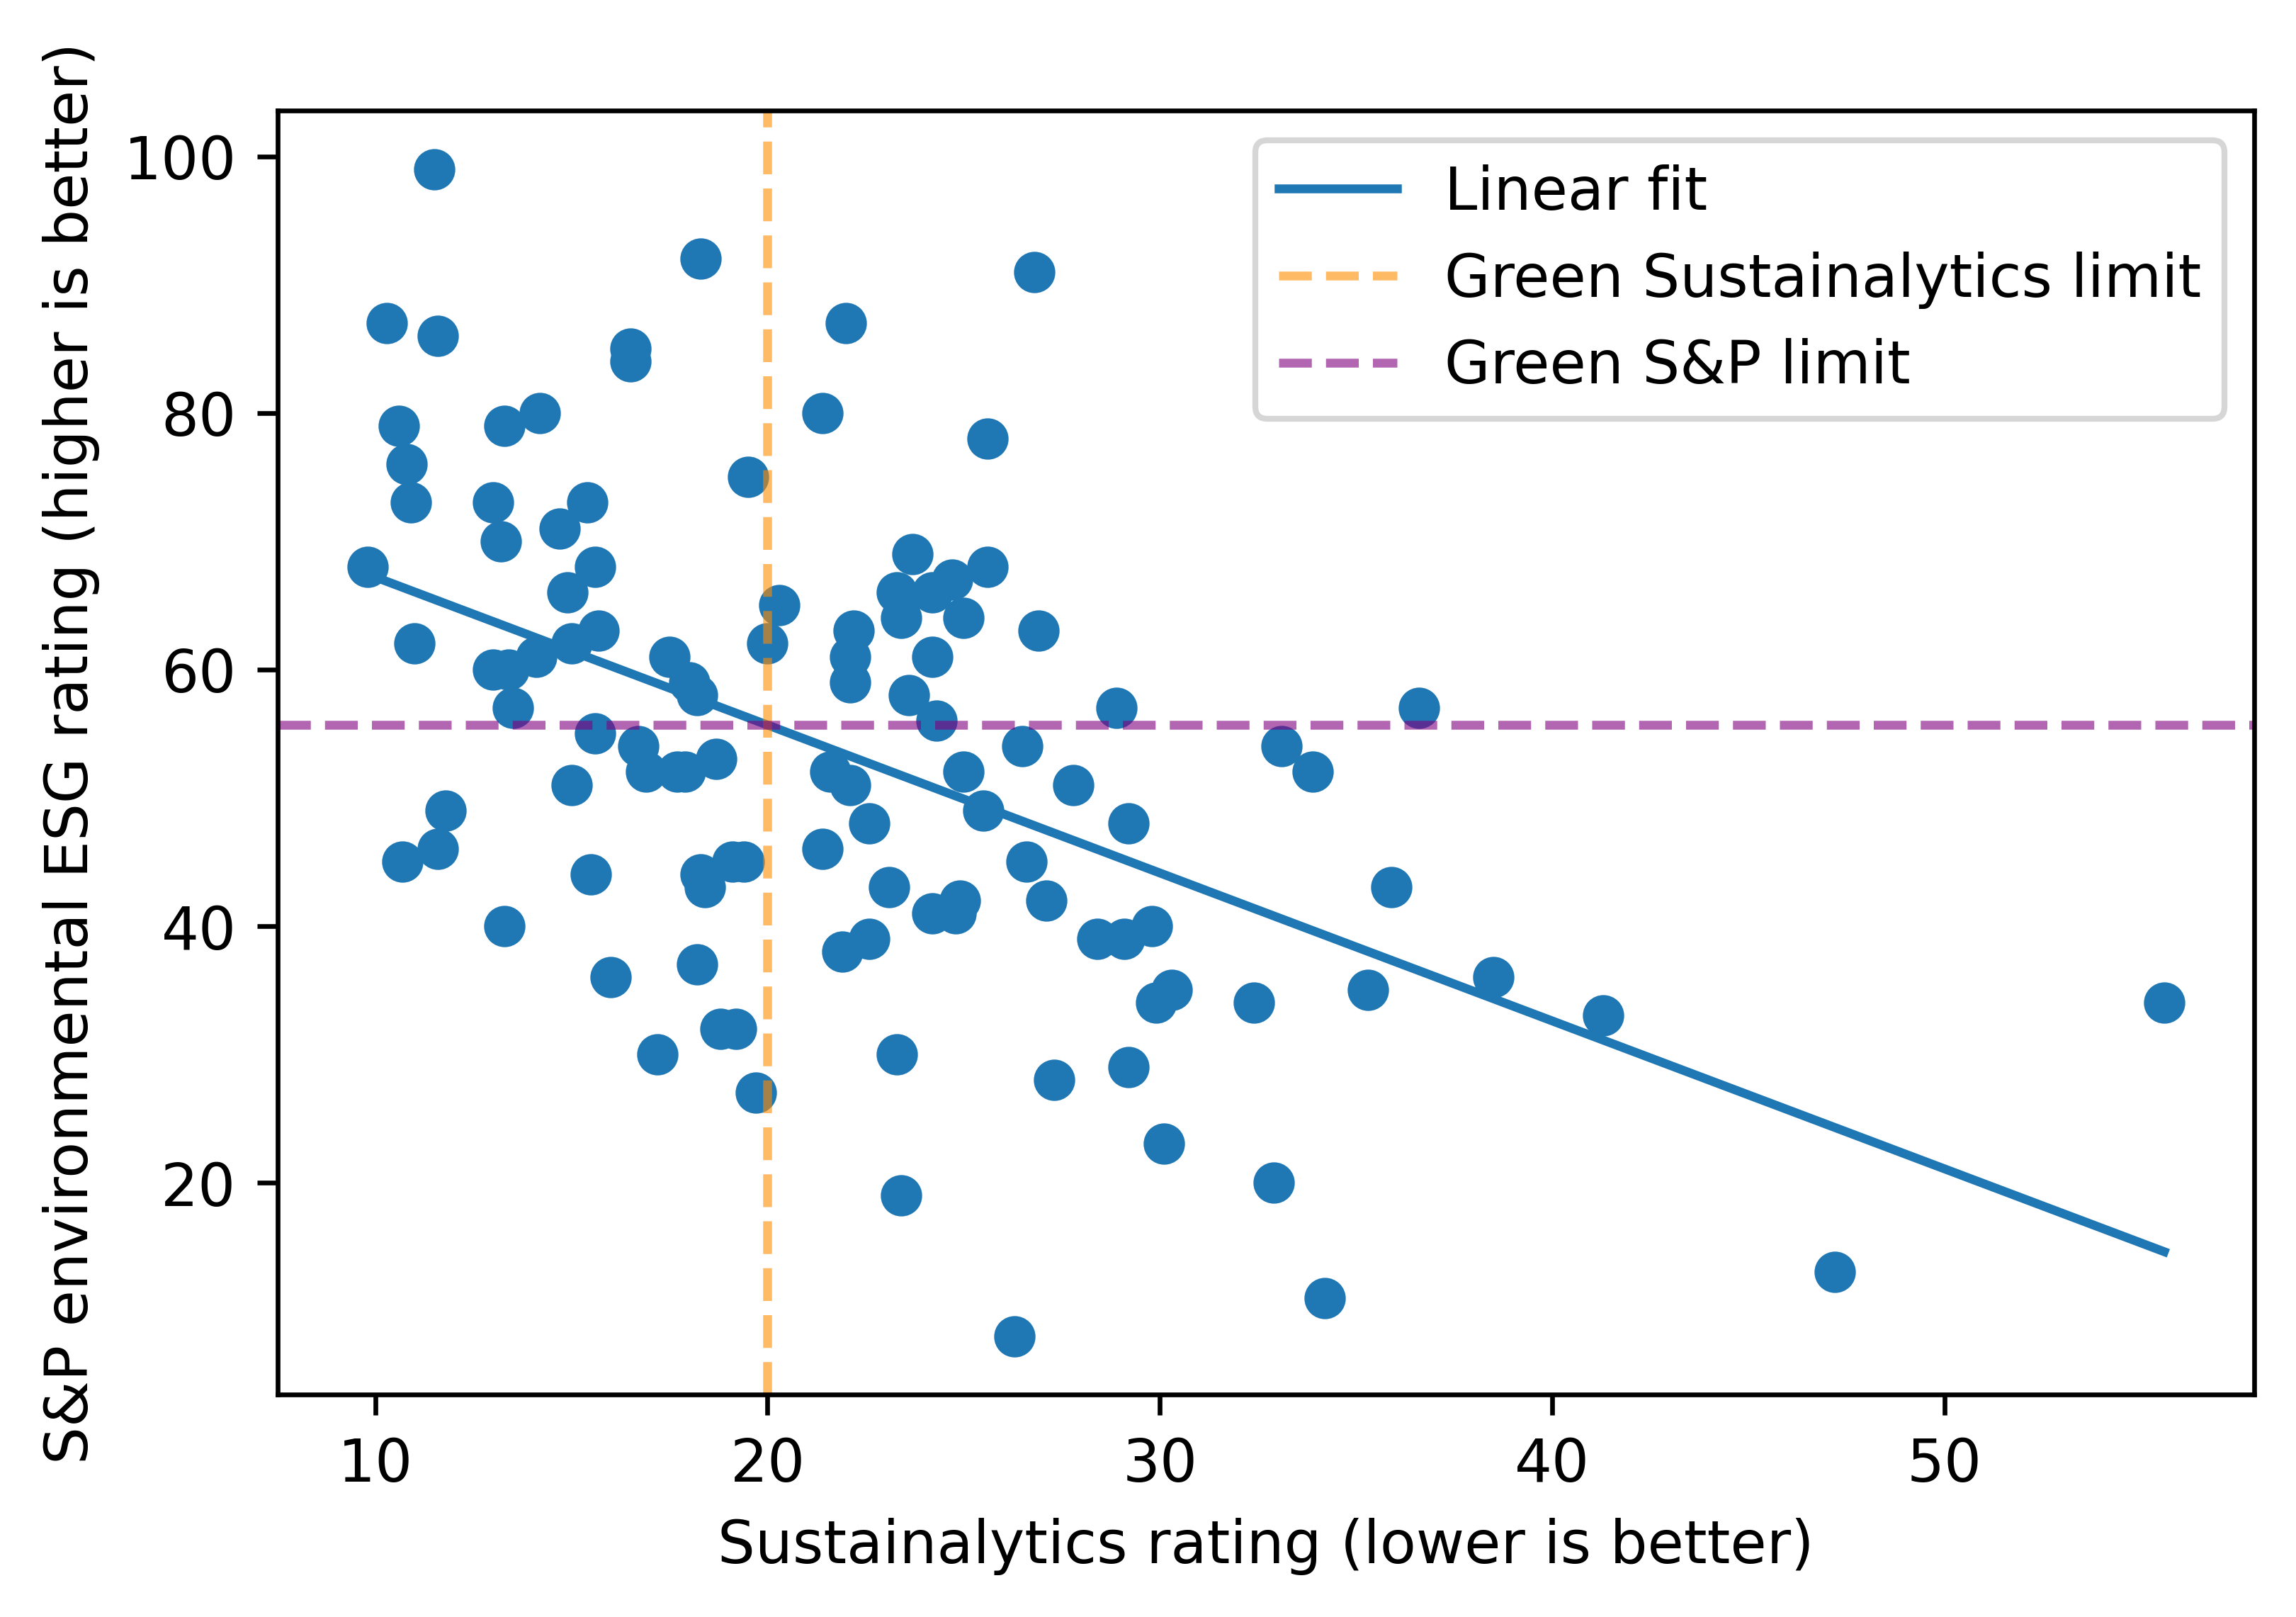

In [14]:
x0 = ratings["Sustainalytics value"]
for y0, ylabel in [
    (ratings["S&P ESG"], "S&P total"), 
    (ratings["S&P ESG environmental"], "S&P environmental")
]:
    mask = ~(x0.isna() | y0.isna())
    x = x0[mask]
    y = y0[mask]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    greenlimit = intercept + 20 * slope
    print(f'Corresponding {ylabel} green limit is {greenlimit}')
    plt.figure(figsize=(6, 4))
    plt.plot(
        [min(x), max(x)], 
        [slope * min(x) + intercept, slope* max(x) + intercept], label=f'Linear fit')
    plt.scatter(x, y)
    plt.axvline(x=20, color='darkOrange', linestyle='--', alpha=0.6, label="Green Sustainalytics limit")
    plt.axhline(y=greenlimit, color='purple', linestyle='--', alpha=0.6, label="Green S&P limit")

    # Add labels and legend
    plt.xlabel("Sustainalytics rating (lower is better)")
    plt.ylabel(ylabel + " ESG rating (higher is better)")
    plt.legend()
    plt.show()

In [15]:
# Calculate the length of the events for general information
df = pd.read_csv("./input/COPdates.txt", delimiter="|")
df.columns = df.columns.str.strip()
df

,Unnamed: 0,Original String,Start,End,Unnamed: 4
0,NaN,28 March to 7 April 1995,1995-03-28,1995-04-07,NaN
1,NaN,8–19 July 1996,1996-07-08,1996-07-19,NaN
2,NaN,1–11 December 1997,1997-12-01,1997-12-11,NaN
3,NaN,2–14 November 1998,1998-11-02,1998-11-14,NaN
4,NaN,25 October and 5 November 1999,1999-10-25,1999-11-05,NaN
5,NaN,13–25 November 2000,2000-11-13,2000-11-25,NaN
6,NaN,29 October to 10 November 2001,2001-10-29,2001-11-10,NaN
7,NaN,23 October to 1 November 2002,2002-10-23,2002-11-01,NaN
8,NaN,1–12 December 2003,2003-12-01,2003-12-12,NaN
9,NaN,6–17 December 2004,2004-12-06,2004-12-17,NaN


In [16]:
df["Start"] = pd.to_datetime(df["Start"])
df["End"] = pd.to_datetime(df["End"])

df["Days_Diff"] = (df["End"] - df["Start"]).dt.days
df["Days_Diff"]

0     10
1     11
2     10
3     12
4     11
5     12
6     12
7      9
8     11
9     11
10    11
11    11
12    12
13    11
14    11
15    12
16    11
17    11
18    12
19    11
20    12
21    11
22    11
23    11
24    11
25    12
26    14
27    12
28    11
Name: Days_Diff, dtype: int64